## Fraud Detection classification

In [2]:
import pandas as pd

df = pd.read_csv('Fraud.csv')

Having a look through the first few rows we can see there are a number of things that immediately stand out. Already I can see a number of different data types including binary (step, isFraud, isFlaggedFraud), text (type, nameOrig, nameDest) and continuous (amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest). As we go through we will need to perform a number of pre-processing steps before this is ready for our model.

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Using the describe function in pandas is useful to see if there are any noticeable characteristics of the dataset or outliers present. Something I notice here is that the variables 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest' and 'newbalanceDest' have a huge range in comparison to some of the other variables. For example, whilst 'amount' ranges from 0 to 92,445,520 we know some of the categorical values, such as 'type' once converted to numerical values will have a small range from 0 to 5. This will be a problem unless rectified as many algorithms may give more weight to these larger features even if they are less important. This will problem will require scaling.

In [4]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


Here we check how many unique values each column holds. We can see 'type' has 5 unique values and so it seems reasonable to convert these categories into integer values. 

In [5]:
df.nunique(axis=0)

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64

Here I found another pre-processing issue. This is an example of a highly imbalanced dataset as there are substantially more non-fraudulent than fraudulent cases. This could lead to the model being far better at predicting non-fraudulent cases compared to fraudulent cases as it has less data to go on. This can be rectified using sampling methods.

In [6]:
print('Number of 0\'s:', df[df['isFraud']==0]['isFraud'].count())
print('Number of 1\'s:', df[df['isFraud']==1]['isFraud'].count())

Number of 0's: 6354407
Number of 1's: 8213


This last step checks if we have null values in our dataset. Thankfully we do not but if we did we would have several options including either simply removing those rows of data, or using imputation methods to find a value to replace the null value with.

In [7]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

As I thought the bank account names might be important I tried to think of the best way to include them as a variable. In this particular dataset I noticed the bank accounts either begin with a C or M and so I created a new column for each variable relating to bank account names, where I assign a 1 if it begins with C and a 0 if not.  

In [8]:
import numpy as np

# df[df['nameOrig'].str.startswith('T')]
df[df['nameOrig'].str.match('^(?![CM])')]
df[df['nameDest'].str.match('^(?![CM])')]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


In [9]:
df['nameOrigBeginsWithC'] = np.where(df['nameOrig'].str.startswith('C'), 1, 0)
df['nameDestBeginsWithC'] = np.where(df['nameDest'].str.startswith('C'), 1, 0)
df['nameOrigLength'] = df['nameOrig'].str.len()
df['nameDestLength'] = df['nameDest'].str.len()

In [10]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,nameOrigBeginsWithC,nameDestBeginsWithC,nameOrigLength,nameDestLength
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1,0,11,11
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1,0,11,11
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1,1,11,10
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,1,10,9
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1,0,11,11


The label encoder is applied to the 'type' variable so we can use this in the model. There are 5 unique values and so each category is converted to a number from 1 to 5.

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

In [12]:
df.drop(columns = ['nameOrig','nameDest']).head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,nameOrigBeginsWithC,nameDestBeginsWithC,nameOrigLength,nameDestLength
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,0,0,1,0,11,11
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0,0,1,0,11,11
2,1,4,181.00,181.0,0.00,0.0,0.0,1,0,1,1,11,10
3,1,1,181.00,181.0,0.00,21182.0,0.0,1,0,1,1,10,9
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,0,0,1,0,11,11


We are nearly there but before the data is ready it must be converted to the same data type. In this case we have several object types which must be removed and the rest of the data, whilst numerical, must be converted to the same type, in this case int64.

In [13]:
df.dtypes

step                     int64
type                     int32
amount                 float64
nameOrig                object
oldbalanceOrg          float64
newbalanceOrig         float64
nameDest                object
oldbalanceDest         float64
newbalanceDest         float64
isFraud                  int64
isFlaggedFraud           int64
nameOrigBeginsWithC      int32
nameDestBeginsWithC      int32
nameOrigLength           int64
nameDestLength           int64
dtype: object

In [14]:
for col in df.columns:
    try:
        if df.dtypes[col]!='int64':
            df[col] = df[col].astype('int64')
    except ValueError:
        df.drop([col],axis=1)

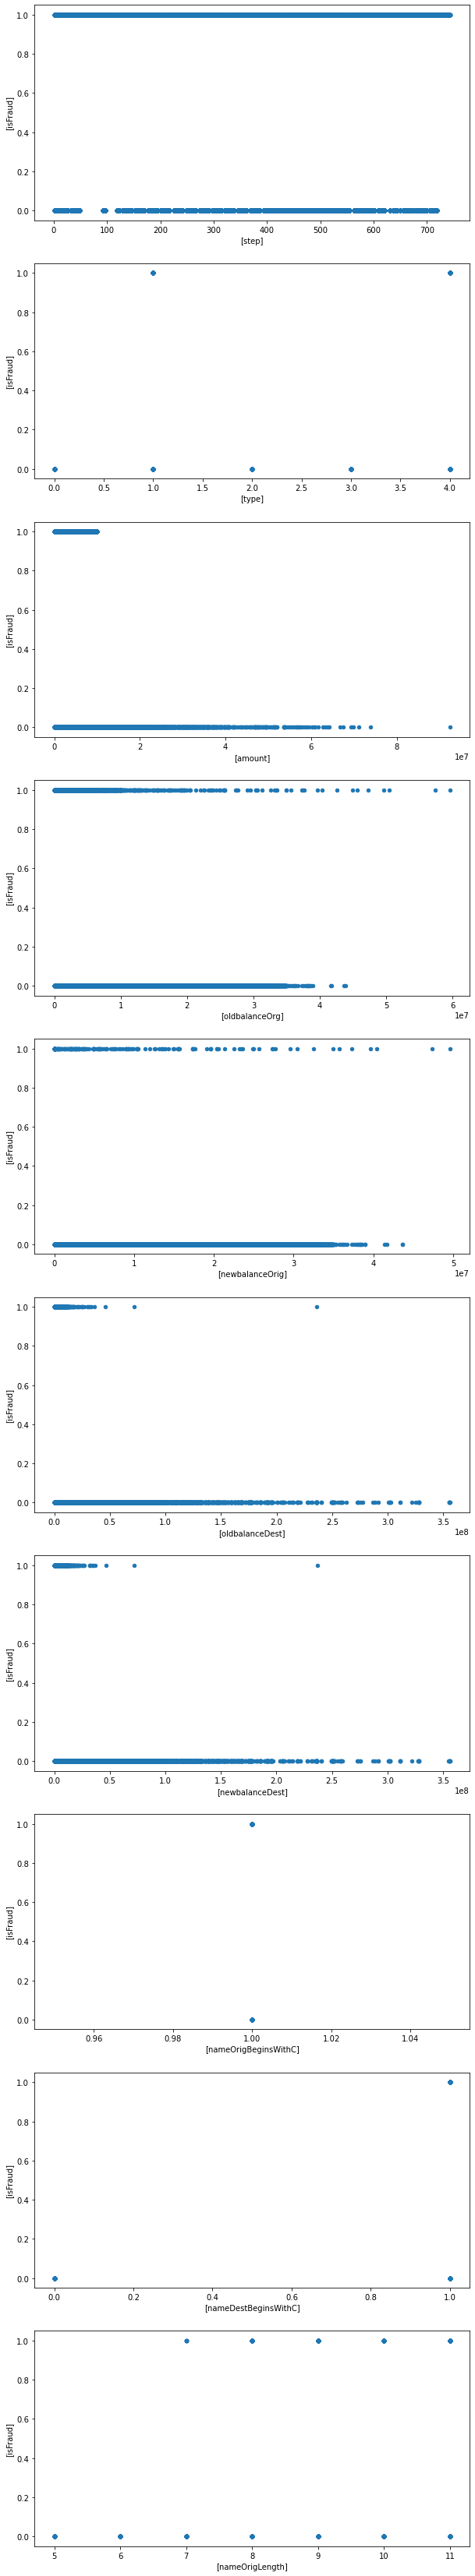

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(df.drop(columns=['nameOrig','nameDest','isFlaggedFraud','isFraud']).columns.values)-1, 1)

for i, col in enumerate(df.drop(columns=['nameOrig','nameDest','isFlaggedFraud','isFraud']).columns.values[:-1]):
    df.plot(x=[col], y=['isFraud'], kind="scatter", ax=axes[i], figsize=(10,60))

plt.show()

As mentioned earlier, we will scale variables that had large ranges using standardization.

In [18]:
cols = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest', 'newbalanceDest', 'nameOrigLength', 'nameDestLength']
for col in cols:
    df[col]=(df[col]-df[col].mean())/df[col].std()

In [19]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,nameOrigBeginsWithC,nameDestBeginsWithC,nameOrigLength,nameDestLength
0,1,3,-0.281560,C1231006815,-0.229810,-0.237622,M1979787155,-0.323814,-0.333411,0,0,1,0,0.856919,0.856890
1,1,3,-0.294767,C1666544295,-0.281359,-0.285812,M2044282225,-0.323814,-0.333411,0,0,1,0,0.856919,0.856890
2,1,4,-0.297554,C1305486145,-0.288654,-0.292442,C553264065,-0.323814,-0.333411,1,0,1,1,0.856919,-0.796547
3,1,1,-0.297554,C840083671,-0.288654,-0.292442,C38997010,-0.317582,-0.333411,1,0,1,1,-0.798398,-2.449984
4,1,3,-0.278531,C2048537720,-0.274329,-0.282221,M1230701703,-0.323814,-0.333411,0,0,1,0,0.856919,0.856890


The sampling method chosen to balance the classes is SMOTE.

In [20]:
from imblearn.over_sampling import SMOTE 


sm = SMOTE(random_state=42)

X = df.drop(columns=['isFraud','nameOrig','nameDest','isFlaggedFraud'],axis=1).to_numpy()
y = df['isFraud'].to_numpy()

X_sm, y_sm = sm.fit_resample(X, y)

We can now see there is now the same amount of data for fraudulent and non-fraudulent cases.

In [21]:
# print('Number of 0\'s:', y_sm[y_sm==0].count())
# print('Number of 1\'s:', y_sm[y_sm==1].count())
print('Number of 0\'s:', (y_sm == 0).sum())
print('Number of 1\'s:', (y_sm == 1).sum())

Number of 0's: 6354407
Number of 1's: 6354407


The first model I will test is a Random Forest classifier. This an ensemble method which will create multiple decision trees and select the class which is most commonly selected by the individual trees. I have chosen a number of metrics to evaluate the performance of this model including accuracy, precision, recall, f-score and supoort:

- Accuracy simply measures the number of correct predictions out of all predictions.
- Precision measures the proportion of correct positive predictions out of all positive predictions.
- Recall measures the proportion of correct positive predictions out of all positive samples.
- F-score is the harmonic mean of the precision and recall of the model.

In this case the Random Forest performs well on all metrics with scores above 98% on each.

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_selection import SequentialFeatureSelector

# sfs = SequentialFeatureSelector(RandomForestRegressor(),n_features_to_select=6, direction='forward')
# X_ = fit_transform(X_sm, y_sm)
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.33, random_state=42)

model = RandomForestRegressor().fit(X_train,y_train)
y_pred = model.predict(X_test)

y_pred = [int(pred) for pred in y_pred]
y_test = [int(test) for test in y_test]

print('Confusion matrix: ', confusion_matrix(y_test, y_pred))
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_recall_fscore_support(y_test, y_pred)[0])
print('Recall: ', precision_recall_fscore_support(y_test, y_pred)[1])
print('F-score: ', precision_recall_fscore_support(y_test, y_pred)[2])
print('Support: ', precision_recall_fscore_support(y_test, y_pred)[3])

Confusion matrix:  [[2097012     100]
 [  25085 2071712]]
Accuracy Score:  0.9939948625494736
Precision:  [0.98817915 0.99995173]
Recall:  [0.99995232 0.98803651]
F-score:  [0.99403087 0.99395842]
Support:  [2097112 2096797]


I wanted to test if I could improve the performance even further by applying Principal component analysis (PCA) to the data. This would transform the data onto the axis which explained most of the variance on the data. In most cases this signficantly reduces the dimensionality of the dataset which helps to overcome the curse of dimensionality and reduce overfitting to specific data. In this case I set it so we would keep the components which explained 95% of the variance in the data. What I found was an improvement in time to complete the classification, however there was a reduction in the performance of all the metrics on this dataset. 

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_sm)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_sm, test_size=0.33, random_state=42)

model = RandomForestRegressor().fit(X_train_pca,y_train_pca)
y_pred_pca = model.predict(X_test_pca)

y_pred_pca = [int(pred) for pred in y_pred_pca]
y_test_pca = [int(test) for test in y_test_pca]

print('Confusion matrix: ', confusion_matrix(y_test_pca, y_pred_pca))
print('Accuracy Score: ', accuracy_score(y_test_pca, y_pred_pca))
print('Precision: ', precision_recall_fscore_support(y_test_pca, y_pred_pca)[0])
print('Recall: ', precision_recall_fscore_support(y_test_pca, y_pred_pca)[1])
print('F-score: ', precision_recall_fscore_support(y_test_pca, y_pred_pca)[2])
print('Support: ', precision_recall_fscore_support(y_test_pca, y_pred_pca)[3])

Confusion matrix:  [[2090662    6450]
 [ 309763 1787034]]
Accuracy Score:  0.9246018451997885
Precision:  [0.87095494 0.99640365]
Recall:  [0.99692434 0.85226848]
F-score:  [0.92969196 0.91871718]
Support:  [2097112 2096797]


I then tested this data using a Naive Bayes classifier. This works using Bayes Theorem to assign a probability that each row of data belongs to a given class and assigning the class that has the highest probability. Whilst there are many more steps I can take using the default parameters in sklearn the intial results show a significant reduction in performance compared to the Random Forest both with and without PCA applied. 

In [25]:
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.33, random_state=42)

model = GaussianNB().fit(X_train,y_train)
y_pred = model.predict(X_test)

y_pred = [int(pred) for pred in y_pred]
y_test = [int(test) for test in y_test]

print('Confusion matrix: ', confusion_matrix(y_test, y_pred))
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_recall_fscore_support(y_test, y_pred)[0])
print('Recall: ', precision_recall_fscore_support(y_test, y_pred)[1])
print('F-score: ', precision_recall_fscore_support(y_test, y_pred)[2])
print('Support: ', precision_recall_fscore_support(y_test, y_pred)[3])

Confusion matrix:  [[ 901972 1195140]
 [  15320 2081477]]
Accuracy Score:  0.7113766655404302
Precision:  [0.98329867 0.63525185]
Recall:  [0.43010197 0.99269362]
F-score:  [0.59844135 0.77473167]
Support:  [2097112 2096797]


In [ ]:
from sklearn import svm
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.33, random_state=42)

model = svm.SVC(kernel= 'linear', random_state= 0).fit(X_train,y_train)
y_pred = model.predict(X_test)

y_pred = [int(pred) for pred in y_pred]
y_test = [int(test) for test in y_test]

print('Confusion matrix: ', confusion_matrix(y_test, y_pred))
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_recall_fscore_support(y_test, y_pred)[0])
print('Recall: ', precision_recall_fscore_support(y_test, y_pred)[1])
print('F-score: ', precision_recall_fscore_support(y_test, y_pred)[2])
print('Support: ', precision_recall_fscore_support(y_test, y_pred)[3])